The S414 is a slotted, natural-laminar-flow airfoil. It is designed to have a laminar bucket between CL=.1 and CL=.65, but also have the ability to achieve high angles of attack and lift coefficients[1]. Below, the windtunnel results and the CFD results from the literature are compared to the results predicted by viiflow.
For OVERFLOW, the transition model in [2] was used.

**Important:** The use of this airfoil is restricted [3]. The geometry of the geometry used here is *not* the geometry used in the other CFD analysis methods nor in the wind tunnel experiments. It has been digitzed and smoothed, with permission, from the reference.
As such, this is not a thorough comparison of CFD results and wind tunnel data, but merely an example of Multi-Element airfoil analysis. The good match should therefore be taken with a tbsp. of salt.

All CFD methods use a transition model, and all are able to predict the laminar bucket and show good agreement with the measurements. Viiflow does predict a stronger increase in drag below the laminar bucket compared to the other methods and the windtunnel results. All methods overpredict maximum lift, with viiflow and MSES closely agreeing on the lift slope, which is not surprising given their similar boundary layer formulation.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

interactive_plot = False
# For interactive plots uncomment the following
'''
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = [12, 6] # Make plots bigger than default
interactive_plot = True
lines = None
fig, ax = plt.subplots(1,1)
''';

AL: -5.000000 CL: -0.135901 CD0: 0.009043 CD1: 0.003650
AL: -4.800000 CL: -0.109796 CD0: 0.008900 CD1: 0.003651
AL: -4.600000 CL: -0.082560 CD0: 0.008781 CD1: 0.003650
AL: -4.400000 CL: -0.059447 CD0: 0.008513 CD1: 0.003655
AL: -4.200000 CL: -0.037782 CD0: 0.008329 CD1: 0.003663
AL: -4.000000 CL: -0.015457 CD0: 0.007606 CD1: 0.003674
AL: -3.800000 CL: 0.005994 CD0: 0.005487 CD1: 0.003664
AL: -3.600000 CL: 0.028695 CD0: 0.004085 CD1: 0.003256
AL: -3.400000 CL: 0.049738 CD0: 0.004079 CD1: 0.003333
AL: -3.200000 CL: 0.081655 CD0: 0.004106 CD1: 0.003406
AL: -3.000000 CL: 0.111607 CD0: 0.004074 CD1: 0.003534
AL: -2.800000 CL: 0.136948 CD0: 0.004023 CD1: 0.003650
AL: -2.600000 CL: 0.158182 CD0: 0.004011 CD1: 0.003655
AL: -2.400000 CL: 0.179235 CD0: 0.004007 CD1: 0.003665
AL: -2.200000 CL: 0.200498 CD0: 0.004006 CD1: 0.003675
AL: -2.000000 CL: 0.222013 CD0: 0.004006 CD1: 0.003683
AL: -1.800000 CL: 0.244271 CD0: 0.004012 CD1: 0.003694
AL: -1.600000 CL: 0.266252 CD0: 0.004019 CD1: 0.003689
AL: 

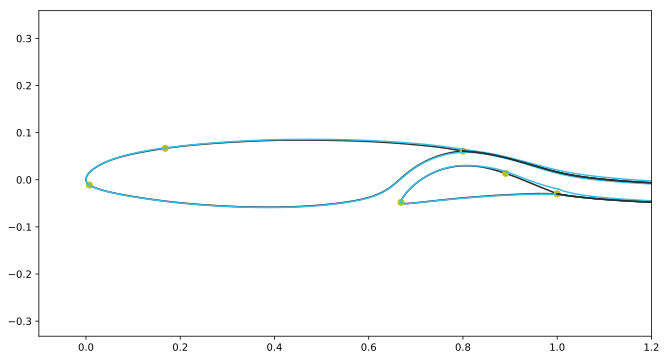

In [2]:
# Read and repanel airfoil data
BASE = vft.repanel(vft.read_selig("S414Main.dat")[:,::-1],160)
SLOT = vft.repanel(vft.read_selig("S414Aft.dat")[:,::-1],160)
# More refined in laminar bucket
AOARANGE = np.r_[np.arange(-5,5,0.2),np.arange(5,20.5,0.5)]

# Scale to c=1
SCALE = np.max(SLOT[0,:])
BASE = BASE/SCALE;
SLOT = SLOT/SCALE;

# Setup
RE = 1.0e6
ncrit = 11.2
Mach = 0.1
AOA0 = AOARANGE[0]
s = vf.setup(Re=RE,Ma=Mach,ncrit=ncrit,alpha=AOA0)
s.iterate_wakes = False
s.silent = True

# For interactive plot. We iterate for 10 iterations and, if not converged, can observe the solution.
s.itermax = 10 


# Use XFOIL Defaults
# When you uncomment this, the results will be closer to those of MSES
#s.LocusA = 6.70
#s.LocusB = 0.75


# Set-up and initialize based on inviscid panel solution
(p,bl,x) = vf.init([BASE,SLOT],s)

# result array
alv = []
clv = []
cdv = []

lines = None # For plot function
for alpha in AOARANGE:
    s.alpha = alpha
    res = None
    grad = None
    for k in range(int(100/s.itermax)): # Make effectively 100 iterations, but show some in between
        [x,flag,res,grad,_] = vf.iter(x,bl,p,s,res,grad)
        
        
        # Plot geometry and update interactively
        if interactive_plot:
            nres=np.sqrt(np.dot(res.T,res))
            lines = vfp.plot_geometry(ax,p,bl,lines)
            title = "AOA %f RES %f"%(alpha,nres)
            ax.set_title(title)
            fig.canvas.draw()
        # Just plot a single geometry at AOA = 5°
        elif alpha==5:
            matplotlib.rcParams['figure.figsize'] = [11, 6] # Make plots bigger than default
            fig, ax = plt.subplots(1,1)
            lines = vfp.plot_geometry(ax,p,bl,lines)

        # Decide whether to stop iterating
        if flag>0:
            alv.append(alpha)
            clv.append(p.CL)
            cdv.append(bl[0].CD+bl[1].CD)
            print('AL: %f CL: %f CD0: %f CD1: %f' % (alpha,clv[-1],bl[0].CD,bl[1].CD) ) 
            break


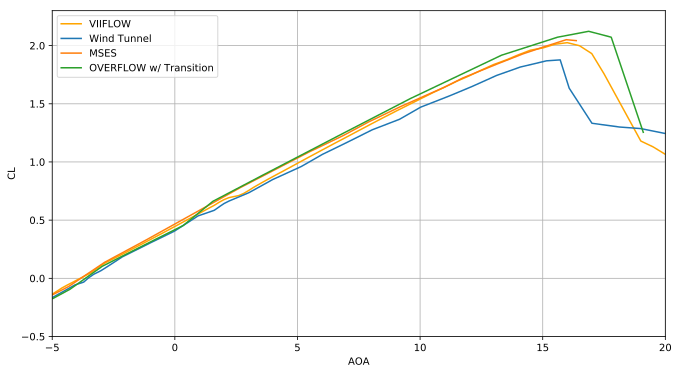

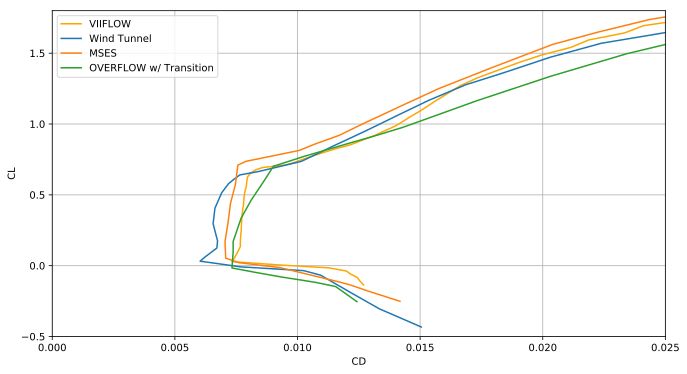

In [3]:
# Load airfoil measurement data
PolarMaughmerWT = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[0,1])
PolarMaughmerMSES = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[2,3])
PolarMaughmerOVERFLOW = np.genfromtxt("MaughmerPolar.csv",skip_header=2,delimiter=",",usecols=[4,5])
CLMaughmerWT = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[0,1])
CLMaughmerMSES = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[2,3])
CLMaughmerOVERFLOW = np.genfromtxt("MaughmerCL.csv",skip_header=2,delimiter=",",usecols=[4,5])

# Make a new plot with the results
fig,ax = plt.subplots(1,1)
ax.plot(alv,clv,color="orange")
ax.plot(CLMaughmerWT.T[0],CLMaughmerWT.T[1])
ax.plot(CLMaughmerMSES.T[0],CLMaughmerMSES.T[1])
ax.plot(CLMaughmerOVERFLOW.T[0],CLMaughmerOVERFLOW.T[1])


ax.set_xlabel('AOA')
ax.set_ylabel('CL')
ax.legend(['VIIFLOW','Wind Tunnel','MSES','OVERFLOW w/ Transition'])
ax.grid(1)
ax.set_xlim([-5,20])
ax.set_ylim([-0.5,2.3])

fig,ax = plt.subplots(1,1)
ax.plot(cdv,clv,color="orange")
ax.plot(PolarMaughmerWT.T[0]/1000,PolarMaughmerWT.T[1])
ax.plot(PolarMaughmerMSES.T[0]/1000,PolarMaughmerMSES.T[1])
ax.plot(PolarMaughmerOVERFLOW.T[0]/1000,PolarMaughmerOVERFLOW.T[1])

ax.set_xlabel('CD')
ax.set_ylabel('CL');
ax.legend(['VIIFLOW','Wind Tunnel','MSES','OVERFLOW w/ Transition'])
ax.set_xlim([0,0.025])
ax.set_ylim([-0.5,1.8])
ax.grid(1)

[1] Mark D. Maughmer, James G. Coder, and Dan M. Somers, *Exploration of a Slotted, Natural-Laminar-Flow Airfoil Concept*, 2018 Applied Aerodynamics Conference. Atlanta, Georgia. 

[2] James G. Coder and Mark D. Maughmer, *Fluid Dynamics Compatible Transition Modeling Using an Amplification Factor Transport Equation*, AIAA Journal 2014 52:11, 2506-2512 

**[3] The original coordinates, and the concept of this airfoil, are patented under US Patent 6905092 B2.
To use this proprietary airfoil, a license agreement with *Airfoil, Incorporated* is necessary and its use is subject to distribution restrictions imposed by the U.S. Army.**